# Plot the retrieved motifs from synthetic datasets (Figure 1C, S1)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import os
from os.path import isfile, join
from itertools import compress
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.backends.backend_pdf
from scipy.stats import nbinom, sem, t
from matplotlib.lines import Line2D

## helper functions

In [2]:
def generate_kmer_inx():
    vals = {'A':0,'C':1,'G':2,'U':3}
    l = 3 #core length
    kmer_inx = {}
    for p in list(itertools.product(vals.keys(), repeat=l)):
        inx = 0
        for j,base in enumerate(p):
            inx += (4**j)*vals[base] 
        kmer_inx[''.join(p)] = inx
    return kmer_inx

#assignes each kmer to an index and visa versa
kmer_inx = generate_kmer_inx()
inx_kmer = {y:x for x,y in kmer_inx.items()}

In [3]:
#reads the np.array files and extract the parameters
#the distance parameters (last 3) are exp'ed to stay positive
def read_params(files):
    n_additional = 1 #non parameters saved at the end
    n_exped = 3 #parameters kept positive through log exp trick
    params = []
    for f in files:
        param = np.loadtxt(join(param_dir, f))
        param[-n_additional-n_exped:-n_additional] = np.exp(param[-n_additional-n_exped:-n_additional])
        param[-n_additional-1] = param[-n_additional-1]/(1+param[-n_additional-1])
        params.append(param)      
    return params

## helper plotting functions

In [4]:
def plot_core_logo(data, ax, color_scheme):
    k=len(data[0][0])
    scalings = [d[1] for d in data]
    total = sum(scalings)
    font_prop = matplotlib.font_manager.FontProperties(family="sans-serif", weight="bold")

    letter_heights = {}
    letter_widths = {}
    for l in "ACGTU":
        lp = matplotlib.textpath.TextPath((0,0), l, size=20, prop=font_prop)
        ext = lp.get_extents()
        letter_heights[l] = ext.y1 - ext.y0
        letter_widths[l] = ext.x1 - ext.x0
    max_letter_height = max(letter_heights.values())
    max_letter_width = max(letter_widths.values())

    letter_scalings = {k:max_letter_height/v for k,v in letter_heights.items()}

    indiv_yscaling = {}
    paths = []
    for kmer, scaling in data:
        row = []
        for letter in kmer:
            txt = matplotlib.textpath.TextPath((0,0), letter, size=20, prop=font_prop)
            txt._letter = letter
            row.append(txt)
        paths.append(row)

    scaled_height = total * max_letter_height

    transformed_paths = []
    cur_top = 0
    for row_paths, scaling in zip(paths, scalings):
        cur_x = 0
        for i, path in enumerate(row_paths): 
            sy = scaling/scaled_height * letter_scalings[path._letter]
            sx = 0.03
            path_t = path.transformed(matplotlib.transforms.Affine2D().scale(sx=sx, sy=sy).translate(tx=cur_x, ty=cur_top))
            path_t._letter = path._letter
            transformed_paths.append(path_t)
            ext = path_t.get_extents()
            cur_x += max_letter_width*sx#(ext.x1 - ext.x0)* 1.1
        cur_top += ext.y1 - ext.y0


    for path in transformed_paths:
        obj = matplotlib.patches.PathPatch(path, edgecolor="black", facecolor=color_scheme[path._letter], lw=0.5)
        ax.add_patch(obj)

    ax.set_ylim(0, 1)
    ax.set_xlim(0, k/2)
    ax.get_xaxis().set_visible(False)
    sns.despine(ax=ax, trim=True)

In [5]:
def energy2prob(energy_series, top_n=5):
    
    probabilities = np.exp(-energy_series)/np.sum(np.exp(-energy_series))
    probabilities_sorted = probabilities.sort_values(ascending=False)
    
    top_kmers = probabilities_sorted[:top_n]
    top_kmers_formatted = [(inx, val) for inx, val in zip(top_kmers.index, top_kmers.values)]
    return top_kmers_formatted

In [6]:
def plot_logo(adam_params, file_name):
    
    colnames = [inx_kmer[i] for i in range(len(inx_kmer))] + [inx_kmer[i] for i in range(len(inx_kmer))] + ['sf', 'r', 'p'] + ['LL']
    data = pd.DataFrame(adam_params, columns=colnames)
    core1 = data.sort_values(by='LL').iloc[0,:len(kmer_inx)]
    core1_probs = energy2prob(core1, top_n=5)

    core2 = data.sort_values(by='LL').iloc[0,len(kmer_inx):2*len(kmer_inx)]
    core2_probs = energy2prob(core2, top_n=5)

    r = data.sort_values(by='LL')['r'].values[0]
    p = data.sort_values(by='LL')['p'].values[0]

    sns.set_style("ticks")
    sns.despine(trim=True)

    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen',
                    'U': 'darkgreen'
                   }

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(4.5, 1.5))
    plot_core_logo(core1_probs, ax1, color_scheme=COLOR_SCHEME)
    plot_core_logo(core2_probs, ax3, color_scheme=COLOR_SCHEME)

    #plot distance
    mean = ((1-p)*r)/(p)
    xx = np.arange(0,int(mean)+8,1)
    
    _ = ax2.plot(xx, nbinom.pmf(xx, r, p), 'o--',alpha=0.7, color='black')
    _ = ax2.set_xlabel('distance')
    
    #not show y axis in the plot
    ax2.set_frame_on(False)
    _ = ax2.get_yaxis().set_visible(False)
    xmin, xmax = ax2.get_xaxis().get_view_interval()
    ymin, ymax = ax2.get_yaxis().get_view_interval()
    ax2.add_artist(Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))


    _ = ax3.set_yticks(range(0,2))
    _ = ax3.set_yticklabels(np.arange(0,2,1))

    _ = ax3.get_xaxis().set_visible(False)
    _ = ax1.set_ylabel('probability')
    sns.despine(ax=ax2, trim=True)
    sns.despine(ax=ax3, trim=True)

    plt.savefig(file_name, bbox_inches='tight')

In [7]:
def plot_logo_real(core1, core2, r, p, file_name):
    
    core1_probs = [(kmer,1/len(core1)) for kmer in core1]
    core2_probs = [(kmer,1/len(core1)) for kmer in core2]

    sns.set_style("ticks")
    sns.despine(trim=True)

    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen',
                    'U': 'darkgreen'
                   }

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(4.5, 1.5))
    plot_core_logo(core1_probs, ax1, color_scheme=COLOR_SCHEME)
    plot_core_logo(core2_probs, ax3, color_scheme=COLOR_SCHEME)

    #plot distance
    mean = ((1-p)*r)/(p)
    xx = np.arange(0,int(mean)+8,1)
    
    _ = ax2.plot(xx, nbinom.pmf(xx, r, p), 'o--',alpha=0.7, color='black')
    _ = ax2.set_xlabel('distance')
    
    #not show y axis in the plot
    ax2.set_frame_on(False)
    _ = ax2.get_yaxis().set_visible(False)
    xmin, xmax = ax2.get_xaxis().get_view_interval()
    ymin, ymax = ax2.get_yaxis().get_view_interval()
    ax2.add_artist(Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

    ax1.set_frame_on(False)
    _ = ax1.get_yaxis().set_visible(False)
    _ = ax1.get_xaxis().set_visible(False)
    
    ax3.set_frame_on(False)
    _ = ax3.get_yaxis().set_visible(False)
    _ = ax3.get_xaxis().set_visible(False)
    
    sns.despine(ax=ax2, trim=True)

    plt.savefig(file_name, bbox_inches='tight')

## read files

In [8]:
param_dir = 'synthetic'
plot_dir = 'synthetic'

#keyword specifies the starting name of all param files
keyw = 'AAat_CCcg_5'  #the keyword which assigns the files to a batch

n_orig = 40
p_orig = 0.9

param_files = [f for f in os.listdir(param_dir) if isfile(join(param_dir, f))]

to_pick = [s.startswith(keyw) & s.endswith('.txt') for s in param_files]
param_files = list(compress(param_files, to_pick))

In [9]:
print('number of files: %d'%len(param_files))
adam_params = read_params(param_files)

number of files: 10


## Logo Plots

<Figure size 432x288 with 0 Axes>

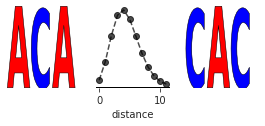

In [10]:
core1 = ['ACA']
core2 = ['CAC']
plot_logo_real(core1, core2, r=n_orig, p=p_orig, file_name=f'synthetic/{keyw}_seqlogo_real.pdf')

<Figure size 432x288 with 0 Axes>

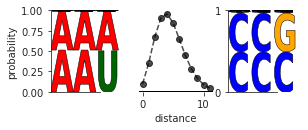

In [11]:
plot_logo(adam_params, f'synthetic/{keyw}_seqlogo2.pdf')

## Output variation from different parameter initializations

In [12]:
param_dir = 'synthetic'
plot_dir = 'synthetic'

#keyword specifies the starting name of all param files
keyw = 'AAat_CCcg'  #the keyword which assigns the files to a batch

n_orig = 40
p_orig = 0.9

param_files = [f for f in os.listdir(param_dir) if isfile(join(param_dir, f))]

to_pick = [s.startswith(keyw) & s.endswith('.txt') for s in param_files]
param_files = list(compress(param_files, to_pick))

In [13]:
print('number of files: %d'%len(param_files))
adam_params = read_params(param_files)

number of files: 10


In [14]:
#structure data as pandas DF
colnames = [inx_kmer[i] for i in range(len(inx_kmer))] + [inx_kmer[i] for i in range(len(inx_kmer))] + ['sf', 'r', 'p'] + ['LL']

data = pd.DataFrame(adam_params, columns=colnames)
core1 = data.iloc[:,:len(kmer_inx)]
core1 = core1.loc[:,core1.median().sort_values().index]
core2 = data.iloc[:,len(kmer_inx):2*len(kmer_inx)]
core2 = core2.loc[:,core2.median().sort_values().index]

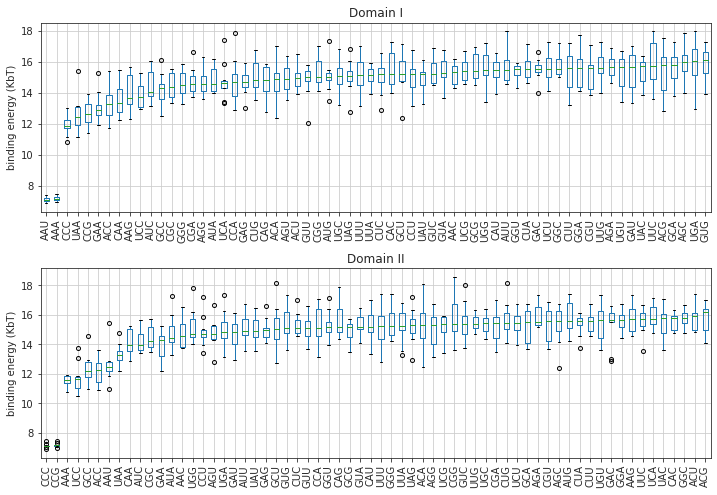

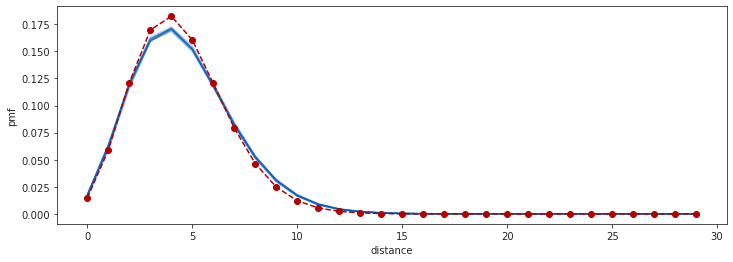

In [15]:
pdf = matplotlib.backends.backend_pdf.PdfPages(os.path.join(plot_dir,f'{keyw}_motif2.pdf'))

#=== plot motifs =================
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
plt.subplots_adjust(hspace=0.3)

flierprops = dict(marker='o', markersize=4)

core1.boxplot(ax=ax1, rot=90, flierprops=flierprops)
ax1.set_title('Domain I', fontsize=12)
ax1.set_ylabel('binding energy (KbT)', fontsize=10)

core2.boxplot(ax=ax2, rot=90, flierprops=flierprops)
ax2.set_title('Domain II', fontsize=12)
ax2.set_ylabel('binding energy (KbT)', fontsize=10)

pdf.savefig(fig)

#=====================

r = data.sort_values(by='LL')['r'].values
p = data.sort_values(by='LL')['p'].values
ll = -data.sort_values(by='LL')['LL'].values

#== plot distance distributions =================

fig, ax = plt.subplots(figsize=(12,4))

xx = np.arange(30)
cmap = matplotlib.cm.get_cmap('Blues')
colors = (ll-min(ll))/(max(ll)-min(ll))
colors = [cmap(c) for c in colors]

for i in range(len(r)):
    ax.plot(xx, nbinom.pmf(xx, r[i], p[i]), 'o-', alpha=0.3, color='#0059b3', markersize=0, label=f'LL={ll[i]:.1f}')

if True:
    ax.plot(xx, nbinom.pmf(xx, n_orig, p_orig),'o--', markersize=6, color='#b30000')
#ax.legend()    
ax.set_xlabel('distance')
ax.set_ylabel('pmf')
pdf.savefig(fig)

pdf.close()